In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas import datetime
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
from time import time
from fbprophet import Prophet
from causal_impact.causal_impact import CausalImpact
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error

In [2]:
df_final = pd.DataFrame.from_csv('~\\df_final.csv')

In [3]:
df_final= df_final[::-1]

In [4]:
X_train = df_final.drop(['Close: t'], axis=1).values[7:]
X_test = df_final.drop(['Close: t'], axis=1).values[:7]
y_train = df_final['Close: t'].values[7:]
y_test = df_final['Close: t'].values[:7]

[  21.49   42.09   60.2    77.81   92.51  100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.  ]


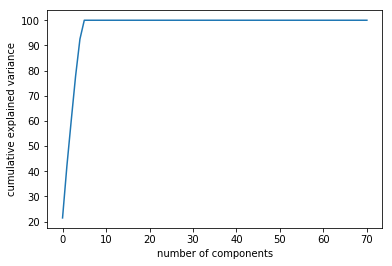

In [5]:
pca_plot = PCA().fit(X_train)
pca_plot = np.cumsum(np.round(pca_plot.explained_variance_ratio_, decimals=4)*100)
plt.plot(pca_plot)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(pca_plot)

In [6]:
n_components = len(pca_plot[pca_plot < 95])
print("Extracting the top %d components from %d variables"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized').fit(X_train)
print("done in %0.3fs" % (time() - t0))

print("Projecting the input data on the orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 5 components from 424 variables
done in 0.016s
Projecting the input data on the orthonormal basis
done in 0.000s


In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def performSVR(X_train, y_train, X_test, y_test):
    """
    SVM Regression
    """
    
    # Fit regression model
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

    # Predict
    y_pred = svr_rbf.fit(X_train, y_train, ).predict(X_test)

    # Measure Accuracy
    accuracy_rbf = mean_absolute_percentage_error(y_test, y_pred)
    
    if np.isinf(accuracy_rbf):
        accuracy_rbf = np.nan
    
    return abs(accuracy_rbf)

In [10]:
def performAdaBoostR(X_train, y_train, X_test, y_test):
    """
    Ada Boosting binary Classification
    """
    # Fit regression model
    #DTR = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
    ADA = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=42).fit(X_train, y_train)

    # Predict
    y_pred = ADA.predict(X_test)
    
    # Measure Accuracy
    accuracy_ADA = mean_absolute_percentage_error(y_test, y_pred)
    
    return abs(accuracy_ADA)

In [12]:
def performRegression(X_train, y_train, X_test, y_test, method):

    print('Performing ' + method + ' Regression...')   
    print('Size of train set: ', X_train.shape)
    print('Size of test set: ', X_test.shape)
   
    if method == 'RF':   
        return performRFClass(X_train, y_train, X_test, y_test)
        
    elif method == 'KNN':
        return performKNNClass(X_train, y_train, X_test, y_test)
    
    elif method == 'SVM':   
        return performSVR(X_train, y_train, X_test, y_test)
    
    elif method == 'ADA':
        return performAdaBoostR(X_train, y_train, X_test, y_test)
    
    elif method == 'GTB': 
        return performGTBClass(X_train, y_train, X_test, y_test)

    elif method == 'QDA': 
        return performQDAClass(X_train, y_train, X_test, y_test)   

In [17]:
# Based on http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/

def performTimeSeriesCV(X_train, y_train, number_folds, algorithm):
    print('Size train set: ', X_train.shape)
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold:', k)
    
    accuracies = np.zeros(number_folds-1)
 
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        
        split = float(i-1)/i
        
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i)) 

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: ', X.shape) # the size of the dataframe is going to be k*i
 
        index = int(np.floor(X.shape[0] * split))
        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        accuracies[i-2] = performRegression(X_trainFolds, y_trainFolds, X_testFold, y_testFold, algorithm)
        print('Accuracy on fold ' + str(i) + ': ', accuracies[i-2])
    
    accuracies[np.isinf(accuracies)] = max(accuracies[~np.isinf(accuracies)])
    accuracies[np.isnan(accuracies)] = max(accuracies[~np.isnan(accuracies)])
    
    # the function returns the mean of the accuracy on the n-1 folds    
    return accuracies.mean()

In [19]:
performTimeSeriesCV(X_train_pca, y_train, number_folds=10, algorithm='SVM')

Size train set:  (424, 5)
Size of each fold: 42

Splitting the first 2 chunks at 1/2
Size of train + test:  (84, 5)
Performing SVM Regression...
Size of train set:  (42, 5)
Size of test set:  (41, 5)
Accuracy on fold 2:  114.14322819

Splitting the first 3 chunks at 2/3
Size of train + test:  (126, 5)
Performing SVM Regression...
Size of train set:  (84, 5)
Size of test set:  (41, 5)
Accuracy on fold 3:  97.7121870798

Splitting the first 4 chunks at 3/4
Size of train + test:  (168, 5)
Performing SVM Regression...
Size of train set:  (126, 5)
Size of test set:  (41, 5)
Accuracy on fold 4:  108.048003909

Splitting the first 5 chunks at 4/5
Size of train + test:  (210, 5)
Performing SVM Regression...
Size of train set:  (168, 5)
Size of test set:  (41, 5)
Accuracy on fold 5:  210.653054954

Splitting the first 6 chunks at 5/6
Size of train + test:  (252, 5)
Performing SVM Regression...
Size of train set:  (210, 5)
Size of test set:  (41, 5)
Accuracy on fold 6:  nan

Splitting the first 

270.6244931562594

In [9]:
performSVR(X_train_pca, y_train, X_test_pca, y_test)

162.05706811897687

In [18]:
performTimeSeriesCV(X_train_pca, y_train, number_folds=10, algorithm='ADA')

Size train set:  (424, 5)
Size of each fold: 42

Splitting the first 2 chunks at 1/2
Size of train + test:  (84, 5)
Performing ADA Regression...
Size of train set:  (42, 5)
Size of test set:  (41, 5)
Accuracy on fold 2:  412.749472026

Splitting the first 3 chunks at 2/3
Size of train + test:  (126, 5)
Performing ADA Regression...
Size of train set:  (84, 5)
Size of test set:  (41, 5)
Accuracy on fold 3:  174.470264389

Splitting the first 4 chunks at 3/4
Size of train + test:  (168, 5)
Performing ADA Regression...
Size of train set:  (126, 5)
Size of test set:  (41, 5)
Accuracy on fold 4:  383.570135629

Splitting the first 5 chunks at 4/5
Size of train + test:  (210, 5)
Performing ADA Regression...
Size of train set:  (168, 5)
Size of test set:  (41, 5)
Accuracy on fold 5:  816.030032414

Splitting the first 6 chunks at 5/6
Size of train + test:  (252, 5)
Performing ADA Regression...
Size of train set:  (210, 5)
Size of test set:  (41, 5)
Accuracy on fold 6:  inf

Splitting the first

623.63354242582182

In [11]:
performAdaBoostR(X_train_pca, y_train, X_test_pca, y_test)

149.24491625056729

In [ ]:
start = datetime(2017, 11, 30) - pd.Timedelta(days=len(X_train_pca))
date = pd.date_range(start, periods=len(X_train_pca), freq='D')[::-1]
X_train_fb = pd.concat([pd.DataFrame(date), pd.DataFrame(y_train)], axis=1)
X_train_fb.columns = ['ds', 'y']

ax = X_train_fb.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Normalized Close')
ax.set_xlabel('Date')

plt.show()